# RNN Model Development

In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [2]:
df = files.upload()

Saving doge-hist-2y Kopie.csv to doge-hist-2y Kopie.csv


In [3]:
df = pd.read_csv(io.BytesIO(df["doge-hist-2y Kopie.csv"]))

In [4]:
df.rename(columns= {"Unnamed: 0": "Date"}, inplace= True)
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format= True)

In [5]:
df = df.set_index("Date")

In [6]:
df.head()

,open,high,low,close,adjclose,volume,ticker
Date,,,,,,,
2019-11-23,0.002145,0.002275,0.002112,0.002273,0.002273,101846258.0,DOGE-EUR
2019-11-24,0.002276,0.002278,0.002085,0.002146,0.002146,92059493.0,DOGE-EUR
2019-11-25,0.002149,0.002151,0.001932,0.002076,0.002076,117692529.0,DOGE-EUR
2019-11-26,0.002077,0.002124,0.002054,0.002078,0.002078,90963851.0,DOGE-EUR
2019-11-27,0.002078,0.002143,0.002025,0.002126,0.002126,91194004.0,DOGE-EUR


In [7]:
df.interpolate(method= "linear", inplace= True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2019-11-23 to 2021-11-23
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      732 non-null    float64
 1   high      732 non-null    float64
 2   low       732 non-null    float64
 3   close     732 non-null    float64
 4   adjclose  732 non-null    float64
 5   volume    732 non-null    float64
 6   ticker    732 non-null    object 
dtypes: float64(6), object(1)
memory usage: 45.8+ KB


In [9]:
df.shape

(732, 7)

# Reshaping Data

In [25]:
## creating train_test_split and scaling values

# instantiating a scaler
scaler = MinMaxScaler()

# selecting relevant column from df
dataset = df.iloc[:,1:2].values

# scaling the data
dataset_scaled = scaler.fit_transform(dataset)

# splitting into train and test data
train, test = train_test_split(dataset_scaled, shuffle = False)

# selecting nr. of days used to predict next value
history_size = 14

# creating arrays X, y for train and test data 
X_train = []
y_train = []

for i in range(history_size, train.size):
  X_train.append(train[i-history_size:i,0])
  y_train.append(train[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []

for i in range(history_size, test.size):
  X_test.append(test[i-history_size:i,0])
  y_test.append(test[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [26]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))

In [27]:
X_train.shape

(535, 14, 1)

# Modeling

In [28]:
# instantiating a model
model = Sequential()

# first network layer
model.add(LSTM(units = 50, return_sequences= True, input_shape = (history_size, 1)))
model.add(Dropout(0.2))

# network layer's 2 - 5
model.add(LSTM(units= 50, return_sequences= True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences= True))
model.add(Dropout(0.2))
model.add(LSTM(units= 50, return_sequences= True))
model.add(Dropout(0.2))
model.add(LSTM(units= 50, return_sequences= True))
model.add(Dropout(0.2))
model.add(LSTM(units= 20, return_sequences= False))
model.add(Dropout(0.2))

# network output layer
model.add(Dense(units= 1))

model.compile(optimizer= "rmsprop", loss= "mse")

In [29]:
model

In [30]:
es = EarlyStopping(patience = 20, restore_best_weights= True)

model.fit(X_train, 
          y_train,
          validation_split= 0.2,
          epochs = 150,
          batch_size= 16,
          callbacks= [es],
          verbose= 1)

Epoch 1/150
27/27 [==============================] - 17s 132ms/step - loss: 2.3759e-04 - val_loss: 0.1607
Epoch 2/150
27/27 [==============================] - 1s 38ms/step - loss: 1.2390e-04 - val_loss: 0.1613
Epoch 3/150
27/27 [==============================] - 1s 39ms/step - loss: 1.3082e-04 - val_loss: 0.1571
Epoch 4/150
27/27 [==============================] - 1s 38ms/step - loss: 1.2382e-04 - val_loss: 0.1621
Epoch 5/150
27/27 [==============================] - 1s 37ms/step - loss: 1.2468e-04 - val_loss: 0.1611
Epoch 6/150
27/27 [==============================] - 1s 37ms/step - loss: 1.1877e-04 - val_loss: 0.1601
Epoch 7/150
27/27 [==============================] - 1s 38ms/step - loss: 1.1637e-04 - val_loss: 0.1562
Epoch 8/150
27/27 [==============================] - 1s 38ms/step - loss: 1.1664e-04 - val_loss: 0.1599
Epoch 9/150
27/27 [==============================] - 1s 38ms/step - loss: 1.1391e-04 - val_loss: 0.1591
Epoch 10/150
27/27 [==============================] - 1s 39ms/

In [ ]:
score = model.evaluate(X_test, y_test, verbose= 0)

print(f"RMSE = {np.sqrt(score)}")

RMSE = 0.07868941985553812


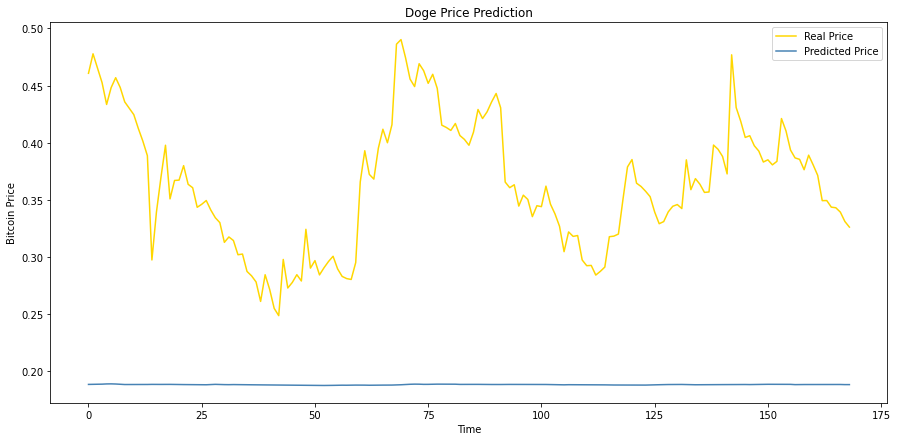

In [ ]:
real_stock_price = y_test

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

plt.figure(figsize= (15,7))
plt.plot(real_stock_price, color = '#ffd700', label = "Real Price")
plt.plot(predicted_stock_price, color = '#4782B4', label = "Predicted Price")
plt.title("Doge Price Prediction")
plt.xlabel("Time")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.show()

# New Preprocessing procedure Test

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

series = train

n_features= 1

series = series.reshape((len(series), n_features))

n_input = 2

generator = TimeseriesGenerator(series, series, length=14, batch_size=8)

model.fit_generator(generator, steps_per_epoch=1, epochs=200, verbose=1)

Epoch 1/200
1/1 [==============================] - 0s 52ms/step - loss: 1.7237e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 2/200
1/1 [==============================] - 0s 64ms/step - loss: 1.7547e-04
Epoch 3/200
1/1 [==============================] - 0s 69ms/step - loss: 1.7812e-04
Epoch 4/200
1/1 [==============================] - 0s 62ms/step - loss: 3.7792e-05
Epoch 5/200
1/1 [==============================] - 0s 65ms/step - loss: 9.7917e-05
Epoch 6/200
1/1 [==============================] - 0s 60ms/step - loss: 5.2635e-05
Epoch 7/200
1/1 [==============================] - 0s 62ms/step - loss: 5.3342e-05
Epoch 8/200
1/1 [==============================] - 0s 62ms/step - loss: 7.5202e-05
Epoch 9/200
1/1 [==============================] - 0s 56ms/step - loss: 4.2089e-05
Epoch 10/200
1/1 [==============================] - 0s 60ms/step - loss: 5.4072e-05
Epoch 11/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0022
Epoch 12/200
1/1 [==============================] - 0s 63ms/step - loss: 9.2173e-05
Epoch 13/200
1/1 [==============================] - 0s 64ms/step - loss: 5.6270e-05
Epoc